In [1]:
%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn
import torch.optim as optim
import os

from utils.config import CONFIG
from utils.data_loader import create_loaders

from models.models_architecture import SRCNN        
from utils.helper_functions import train_sr, test_sr, plot_sr_progress

os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
num_epochs      = CONFIG["training"]["epochs"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]

In [3]:
# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)


📦 DATA LOADED:
  Train: 64800 samples
  Val:   8100 samples
  Test:  8100 samples


In [4]:
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


Epoch 1/10


Training:   0%|          | 0/1013 [00:00<?, ?it/s]

🔥 New best model saved with Val PSNR = 26.04 dB
Train loss: 0.006002 | Train PSNR: 23.99 dB
Val   loss: 0.002944 | Val   PSNR: 26.04 dB
  ➤ LR: 0.00010000

Epoch 2/10


🔥 New best model saved with Val PSNR = 26.18 dB
Train loss: 0.003295 | Train PSNR: 24.85 dB
Val   loss: 0.002858 | Val   PSNR: 26.18 dB
  ➤ LR: 0.00010000

Epoch 3/10


🔥 New best model saved with Val PSNR = 26.25 dB
Train loss: 0.003246 | Train PSNR: 24.91 dB
Val   loss: 0.002816 | Val   PSNR: 26.25 dB
  ➤ LR: 0.00010000

Epoch 4/10


🔥 New best model saved with Val PSNR = 26.29 dB
Train loss: 0.003214 | Train PSNR: 24.96 dB
Val   loss: 0.002786 | Val   PSNR: 26.29 dB
  ➤ LR: 0.00010000

Epoch 5/10


🔥 New best model saved with Val PSNR = 26.32 dB
Train loss: 0.003188 | Train PSNR: 24.99 dB
Val   loss: 0.002767 | Val   PSNR: 26.32 dB
  ➤ LR: 0.00010000

Epoch 6/10


🔥 New best model saved with Val PSNR = 26.37 dB
Train loss: 0.003168 | Train PSNR: 25.02 dB
Val   loss: 0.002740 | Val   PSNR: 26.37 dB
  ➤ LR: 0.00010000

Epoch 7/10


🔥 New best model saved with Val PSNR = 26.37 dB
Train loss: 0.003152 | Train PSNR: 25.04 dB
Val   loss: 0.002737 | Val   PSNR: 26.37 dB
  ➤ LR: 0.00010000

Epoch 8/10


🔥 New best model saved with Val PSNR = 26.41 dB
Train loss: 0.003136 | Train PSNR: 25.06 dB
Val   loss: 0.002712 | Val   PSNR: 26.41 dB
  ➤ LR: 0.00010000

Epoch 9/10


Train loss: 0.003126 | Train PSNR: 25.08 dB
Val   loss: 0.002716 | Val   PSNR: 26.40 dB
  ➤ LR: 0.00010000

Epoch 10/10


Train loss: 0.003116 | Train PSNR: 25.09 dB
Val   loss: 0.002712 | Val   PSNR: 26.40 dB
  ➤ LR: 0.00010000


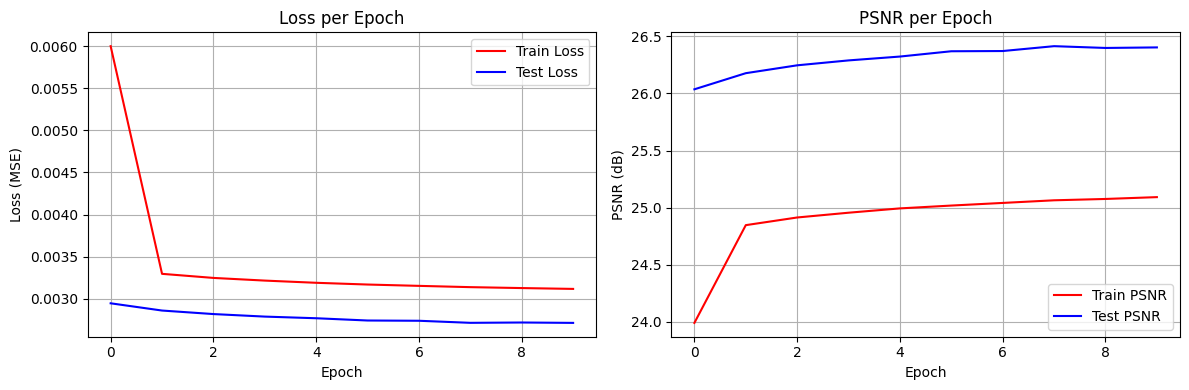

In [15]:
train_losses, val_losses = [], []
train_psnrs,  val_psnrs  = [], []

best_psnr = 0.0
best_model_path = CONFIG["model"]["best_model_path"]
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)



for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_psnr = train_sr(
        model, train_loader, criterion, optimizer, device, scheduler
    )
    val_loss, val_psnr = test_sr(
        model, val_loader, criterion, device
    )


    # save best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), best_model_path)
        print(f"🔥 New best model saved with Val PSNR = {best_psnr:.2f} dB")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_psnrs.append(train_psnr)
    val_psnrs.append(val_psnr)

    print(f"Train loss: {train_loss:.6f} | Train PSNR: {train_psnr:.2f} dB")
    print(f"Val   loss: {val_loss:.6f} | Val   PSNR: {val_psnrs[-1]:.2f} dB")
    print(f"  ➤ LR: {optimizer.param_groups[0]['lr']:.8f}")


plot_sr_progress(train_losses, val_losses, train_psnrs, val_psnrs)
